# CS448 - Lab 7: Pitch tracking and modifications

In [1]:
### IMPORTS & SETUP ###

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 3)

import numpy as np
from scipy.io import wavfile
from scipy.signal import find_peaks, lfilter, butter, freqz
from numpy.fft import irfft

DRAW_GRAPHS = True

In [2]:
### UTILITIES ###


# Sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound(x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display(
        HTML('<style> table, th, td {border: 0px; }</style> <table><tr><td>' +
             label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:] +
             '</td></tr></table>'))


# Function that normalizes a signal
def normalize_signal(x):
    return x / np.max(np.abs(x))


def plot_stft(stft, fs, title=""):
    output = np.absolute(stft)**0.3
    time = np.linspace(0, output.shape[0] * HOP_SIZE / fs, output.shape[0])
    freq = np.linspace(0, fs / 2, int((DFT_SIZE + ZERO_PAD) / 2 + 1))
    plt.pcolormesh(time, freq, output.T)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (HZ)")
    plt.title(title)
    plt.show()


# Function that plots the spectrogram of a signal
def plot_spectrogram(stft,
                     input_sound,
                     fs,
                     max_freq=3000,
                     title="Spectrogram"):
    # Taking the log of the spectrogram to make it more visible
    output = np.log(np.absolute(stft))
    X = np.linspace(0, len(input_sound) / fs, stft.shape[0])

    # # Calculating the frequency axis
    freq = int(max_freq // (fs / 2 / stft.shape[1]) + 1)
    Y = np.linspace(0, max_freq, freq)

    # Plotting the spectrogram
    plt.pcolormesh(X, Y, output.T[:][:freq])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (HZ)")
    plt.title(title)


# Function that plots the frequency response of a filter
def plot_freq_response(w, h, fs, cutoff, title):
    plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
    plt.axvline(cutoff, color='k', linestyle='--')
    plt.xlim(0, 0.5 * fs)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [3]:
# STFT from Lab 1
def stft(input_sound, dft_size, hop_size, zero_pad, window):
    # Creating the n-1 frames
    frames = []
    idx = 0
    for idx in range(0, len(input_sound) - dft_size, hop_size):
        frames.append(np.multiply(input_sound[idx:idx + dft_size], window))
    idx += hop_size

    # Creating the last frame accounting for padding
    last_frame = np.multiply(
        np.append(input_sound[idx:-1],
                  np.zeros(idx + dft_size - len(input_sound) + 1)), window)
    frames.append(last_frame)

    # Convert to numpy array
    frames = np.array(frames, dtype=float)

    # Compute the DFT of each frame
    dft_frames = np.fft.rfft(frames, dft_size + zero_pad)
    return dft_frames


# ISTFT from Lab 1
def istft(stft_output, dft_size, hop_size, zero_pad):
    # Initializing the signal length
    signal_length = (stft_output.shape[0] * hop_size) + dft_size + zero_pad
    signal = np.zeros(signal_length)

    for i in range(stft_output.shape[0]):
        original_signal = np.fft.irfft(stft_output[i, :], dft_size + zero_pad)
        start = i * hop_size
        end = start + original_signal.shape[0]
        signal[start:end] += original_signal

    return signal


# STFT parameters
DFT_SIZE = 2048
HOP_SIZE = DFT_SIZE // 4
ZERO_PAD = 0
WINDOW = np.hanning(DFT_SIZE)

## Part 1: Making a pitch tracker

In this section we will design a pitch tracker. We will apply it on this sound file:

[https://drive.google.com/uc?export=download&id=1gB1MlHQJiXRJRYAauWxdJDcRoYs8q0oM ]

We want to find the pitch of the singing over time, as well as if the sound is pitched or not at any point in time. To do so we will design an autocorrelation pitch tracker.
Do the following:
1. Perform an STFT of the sound
2. Using the DFT representation of each frame compute the frame’s autocorrelation
3. Invert each frame’s autocorrelation back to the time domain
4. Find the first peak after the main peak (the main peak will be at address 0)
    - We will only look for pitches between 100 and 300Hz
	- Which means that you only need to look for a peak at a specific range
5. If the peak is more than 70% of the main peak we have a pitched frame
	- Otherwise it is an un-pitched frame
	
Plot the pitch value over time and see if it correlates with what you are hearing (we also have the correct plot in the lecture slides).


beauty.wav


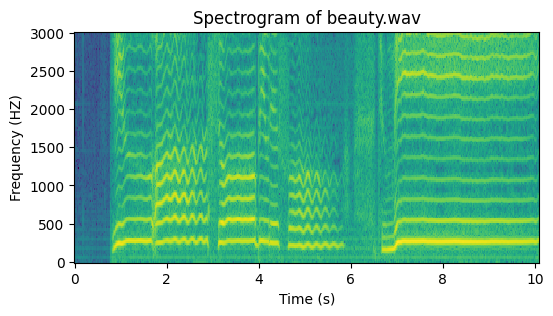

In [4]:
# Loading the sound file
fname = 'beauty.wav'
fs, input_sound = wavfile.read(f'./data/{fname}')
input_sound = normalize_signal(input_sound)

sound(input_sound, rate=fs, label=fname)

stft_out = stft(input_sound, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)
plot_spectrogram(stft_out,
                 input_sound,
                 fs,
                 3000,
                 title=f'Spectrogram of {fname}')


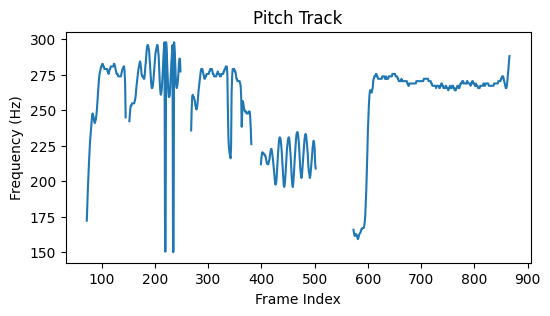

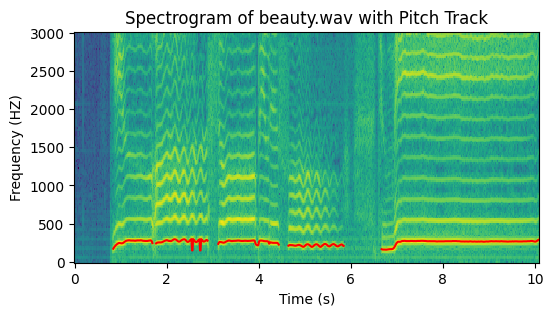

In [5]:
pitch_track = []
for DFT in stft_out:
    row = np.abs(DFT)**2
    autocorrelation = irfft(row, n=DFT_SIZE)
    fundamental = autocorrelation[0]

    peaks, _ = find_peaks(autocorrelation[fs // 300:fs // 100], distance=30)
    peaks += fs // 300
    
    if np.max(autocorrelation[peaks]) > 0.7 * fundamental:
        max_peak_idx = peaks[0]
        max_peak_val = autocorrelation[peaks[0]]
        for i in range(1, len(peaks)):
            if autocorrelation[peaks[i]] > max_peak_val:
                max_peak_idx = peaks[i]
                max_peak_val = autocorrelation[peaks[i]]
        pitch_track.append(fs / max_peak_idx)

    else:
        pitch_track.append(None)

plt.plot(pitch_track)
plt.title("Pitch Track")
plt.xlabel("Frame Index")
plt.ylabel("Frequency (Hz)")
plt.show()

# Plotting the pitch track on the spectrogram
x_vals = []
for i in range(stft_out.shape[0]):
    x_vals.append(i * len(input_sound) / (fs * stft_out.shape[0]))

plot_spectrogram(stft_out, input_sound, fs, title=f'Spectrogram of {fname} with Pitch Track')
plt.plot(x_vals, pitch_track, color='red')

plt.show()


## Part 2. Changing pitch 

We will now correct the pitch of that last horrible note. We will use the zero crossing method to find where the periods are and then we will shift them appropriately to create a pitch of 274Hz.

1. Get samples 303,000 to 445,000 which is the horrible part.

2. Lowpass filter to facilitate the zero crossing finding

    - Pick an appropriate cutoff frequency that will help
    – Use the ```scipy.signal.filtfilt()``` function which will not time-shift the input
    
3. Find the zero crossing points which should be the start of each period

4. For each period get the signal from the previous period’s start till this period’s end

5. Window that signal with a Hann window to remove any discontinuities

6. Overlap add each of the above at a rate appropriate for 274Hz

Play the sound, does it sound more in tune? (it better!)

In [6]:
# Function that creates a butterworth low-pass filter from Lab 1
def butter_low_pass(sound, fs, cutoff):
    b, a = butter(10, cutoff / (fs / 2))
    return lfilter(b, a, sound)

untuned note from beauty.wav (6.9s - 10.1s)


untuned note after filtering with IIR Butterworth


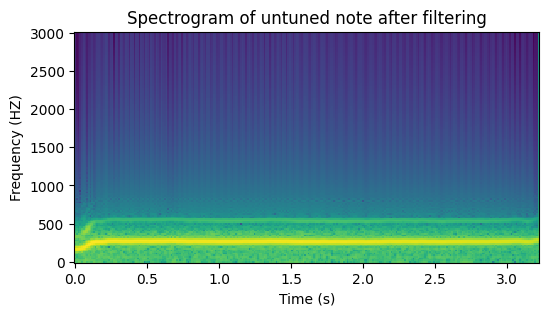

In [7]:
# Selecting the untuned note
start_sample, end_sample = 303000, 445000
untuned_note = input_sound[start_sample:end_sample]
sound(
    untuned_note,
    rate=fs,
    label=
    f'untuned note from {fname} ({round(start_sample/fs, 1)}s - {round(end_sample/fs, 1)}s)'
)

stft_untuned = stft(untuned_note, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)

# Filtering the untuned note
filtered_note = butter_low_pass(untuned_note, fs, 370)

stft_untuned_filtered = stft(filtered_note, DFT_SIZE, HOP_SIZE, ZERO_PAD,
                             WINDOW)

sound(filtered_note,
      rate=fs,
      label='untuned note after filtering with IIR Butterworth')
plot_spectrogram(stft_untuned_filtered,
                 filtered_note,
                 fs,
                 title=f'Spectrogram of untuned note after filtering')